In [3]:
from datasets import load_from_disk
from torch.utils.data import DataLoader

# Load the dataset from disk and set format to 'torch' for PyTorch compatibility
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Display the features of the dataset to ensure it's loaded correctly
print("Features of the dataset:")
print(loaded_dataset.features)

# Create a DataLoader for batch processing
# Setting num_workers=4 to utilize multiple CPU cores for faster data loading
dataloader = DataLoader(loaded_dataset, batch_size=10000, num_workers=4)

# Example: Iterating over the dataloader to fetch the first batch
for batch in dataloader:
    print("First batch loaded successfully.")
    print(batch)  # Inspect the structure of the batch
    break  # Remove this line to iterate over the entire dataset


Features of the dataset:
{'input': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None), 'output': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}
First batch loaded successfully.
{'input': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [4, 7, 6,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 4, 0, 0],
         [0, 0, 0,  ..., 6, 0, 3],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[6, 4, 0,  ..., 0, 0, 0],
         [8, 2, 0,  ..., 0, 0, 0],
         [7, 5, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 6, 3, 8],
         [0, 0, 0,  ..., 0, 9, 0],
         [0, 0, 0,  ..., 4, 7, 5]],

        [[5, 0, 6,  ..., 0, 0, 0],
         [0, 0, 2,  ..., 0, 0, 0],
         [7, 4, 8,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 3, 4, 0],
         [0, 0, 0,  ..., 8, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm  # Import tqdm for progress bar

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk and set format to 'torch' for PyTorch compatibility
# Replace "sudoku_dataset_own_1M" with the path to your dataset if different
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Create a DataLoader for batch processing
dataloader = DataLoader(loaded_dataset, batch_size=128, shuffle=True, num_workers=4)

# Define the neural network model
class SimpleSudokuNN(nn.Module):
    def __init__(self):
        super(SimpleSudokuNN, self).__init__()
        # Input layer: 81 -> Hidden layer 1: 128 -> Hidden layer 2: 128 -> Output layer: 81
        self.model = nn.Sequential(
            nn.Linear(81, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 81)
        )

    def forward(self, x):
        # Flatten the input if it is a 9x9 grid
        x = x.view(-1, 81).float()  # Convert to float32
        return self.model(x)

# Instantiate the model, loss function, and optimizer
model = SimpleSudokuNN().to(device)  # Move model to the GPU
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10  # Number of epochs to train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        # Retrieve input and output from the batch and move to GPU
        inputs = batch['input'].float().to(device)  # Convert inputs to float32 and move to GPU
        outputs = batch['output'].view(-1, 81).float().to(device)  # Convert outputs to float32, flatten, and move to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, outputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate running loss
        running_loss += loss.item()
        
        # Update the progress bar with the current loss
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Print average loss per epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(dataloader):.4f}")


Using device: cuda


Epoch 1/10: 100%|██████████| 7813/7813 [01:19<00:00, 98.66it/s, Loss=0.658] 


Epoch 1/10, Average Loss: 0.9861


Epoch 2/10: 100%|██████████| 7813/7813 [01:19<00:00, 98.79it/s, Loss=0.692] 


Epoch 2/10, Average Loss: 0.6785


Epoch 3/10: 100%|██████████| 7813/7813 [01:23<00:00, 93.02it/s, Loss=0.606] 


Epoch 3/10, Average Loss: 0.6692


Epoch 4/10: 100%|██████████| 7813/7813 [01:25<00:00, 91.16it/s, Loss=0.645] 


Epoch 4/10, Average Loss: 0.6655


Epoch 5/10: 100%|██████████| 7813/7813 [01:26<00:00, 90.69it/s, Loss=0.684] 


Epoch 5/10, Average Loss: 0.6628


Epoch 6/10: 100%|██████████| 7813/7813 [01:15<00:00, 104.10it/s, Loss=0.669]


Epoch 6/10, Average Loss: 0.6604


Epoch 7/10: 100%|██████████| 7813/7813 [01:16<00:00, 102.10it/s, Loss=0.652]


Epoch 7/10, Average Loss: 0.6577


Epoch 8/10: 100%|██████████| 7813/7813 [01:20<00:00, 96.52it/s, Loss=0.67]  


Epoch 8/10, Average Loss: 0.6540


Epoch 9/10: 100%|██████████| 7813/7813 [01:24<00:00, 92.38it/s, Loss=0.62]  


Epoch 9/10, Average Loss: 0.6496


Epoch 10/10: 100%|██████████| 7813/7813 [01:27<00:00, 89.24it/s, Loss=0.617] 

Epoch 10/10, Average Loss: 0.6457


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk and set format to 'torch' for PyTorch compatibility
# Replace "sudoku_dataset_own_1M" with the path to your dataset if different
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Create a DataLoader for batch processing
dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define the neural network model
class SimpleSudokuNN(nn.Module):
    def __init__(self):
        super(SimpleSudokuNN, self).__init__()
        # Input layer: 81 -> Hidden layer 1: 128 -> Hidden layer 2: 128 -> Output layer: 81
        self.model = nn.Sequential(
            nn.Linear(81, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 81)
        )

    def forward(self, x):
        # Flatten the input if it is a 9x9 grid
        x = x.view(-1, 81).float()  # Convert to float32
        return self.model(x)

# Instantiate the model, loss function, and optimizer
model = SimpleSudokuNN().to(device)  # Move model to the GPU
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=0.1)

# List to store loss values
losses = []

# Training the model
num_epochs = 4  # Number of epochs to train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        # Retrieve input and output from the batch and move to GPU
        inputs = batch['input'].float().to(device)  # Convert inputs to float32 and move to GPU
        outputs = batch['output'].view(-1, 81).float().to(device)  # Convert outputs to float32, flatten, and move to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, outputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate running loss
        running_loss += loss.item()
        
        # Store the loss value for plotting
        losses.append(loss.item())
        
        # Update the progress bar with the current loss
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Print average loss per epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(dataloader):.4f}")

# Calculate statistics after all epochs are completed
loss_tensor = torch.tensor(losses, dtype=torch.float32)
mean_loss = torch.mean(loss_tensor).item()
std_loss = torch.std(loss_tensor).item()
median_loss = torch.median(loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(losses) + 1), losses, color='b', label='Loss')  # No markers
ax.axhline(mean_loss, color='r', linestyle='--', label=f'Mean: {mean_loss:.4f}')
ax.axhline(median_loss, color='g', linestyle='--', label=f'Median: {median_loss:.4f}')
ax.fill_between(range(1, len(losses) + 1),
                mean_loss - std_loss,
                mean_loss + std_loss,
                color='orange', alpha=0.3, label=f'Std: {std_loss:.4f}')

ax.set_title('Training Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Epoch 1/4:  28%|██▊       | 4302/15625 [00:26<01:10, 161.33it/s, Loss=2.56]  


KeyboardInterrupt: 

Using device: cuda


Epoch 1/2: 100%|██████████| 15625/15625 [01:37<00:00, 161.05it/s, Loss=0.702]


Epoch 1/2, Average Loss: 0.8946, Accuracy: 29.93%


Epoch 2/2: 100%|██████████| 15625/15625 [01:41<00:00, 154.66it/s, Loss=0.647]


Epoch 2/2, Average Loss: 0.6811, Accuracy: 31.21%


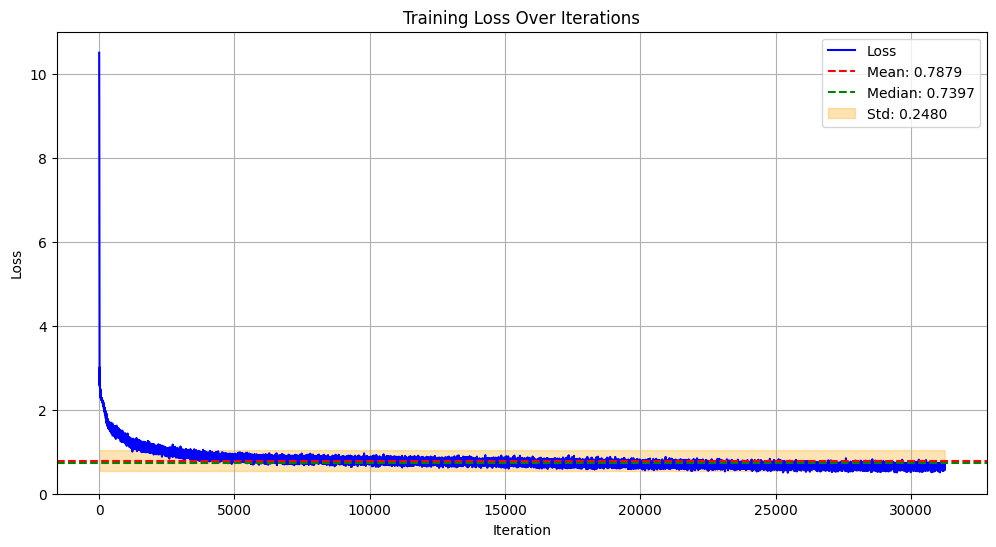

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Create a DataLoader for batch processing
dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define the neural network model
class SimpleSudokuNN(nn.Module):
    def __init__(self):
        super(SimpleSudokuNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(81, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 81)
        )

    def forward(self, x):
        x = x.view(-1, 81).float()
        return self.model(x)

# Instantiate the model, loss function, and optimizer
model = SimpleSudokuNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
losses = []
accuracies = []

# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)
        true_classes = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted_classes == true_classes).sum().item()
        total_predictions += true_classes.size(0)

        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_predictions) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate statistics after all epochs
loss_tensor = torch.tensor(losses, dtype=torch.float32)
mean_loss = torch.mean(loss_tensor).item()
std_loss = torch.std(loss_tensor).item()
median_loss = torch.median(loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(losses) + 1), losses, color='b', label='Loss')
ax.axhline(mean_loss, color='r', linestyle='--', label=f'Mean: {mean_loss:.4f}')
ax.axhline(median_loss, color='g', linestyle='--', label=f'Median: {median_loss:.4f}')
ax.fill_between(range(1, len(losses) + 1),
                mean_loss - std_loss,
                mean_loss + std_loss,
                color='orange', alpha=0.3, label=f'Std: {std_loss:.4f}')

ax.set_title('Training Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Epoch 1/14: 100%|██████████| 15625/15625 [01:45<00:00, 148.13it/s, Loss=0.63] 


Epoch 1/14, Average Loss: 0.8302, Accuracy: 29.46%


Epoch 2/14: 100%|██████████| 15625/15625 [01:49<00:00, 142.80it/s, Loss=0.563]


Epoch 2/14, Average Loss: 0.6346, Accuracy: 31.12%


Epoch 3/14: 100%|██████████| 15625/15625 [01:50<00:00, 141.12it/s, Loss=0.523]


Epoch 3/14, Average Loss: 0.6098, Accuracy: 31.24%


Epoch 4/14: 100%|██████████| 15625/15625 [01:49<00:00, 142.05it/s, Loss=0.545]


Epoch 4/14, Average Loss: 0.5969, Accuracy: 31.41%


Epoch 5/14: 100%|██████████| 15625/15625 [02:53<00:00, 89.85it/s, Loss=0.613]


Epoch 5/14, Average Loss: 0.5875, Accuracy: 32.05%


Epoch 6/14: 100%|██████████| 15625/15625 [03:37<00:00, 71.83it/s, Loss=0.56] 


Epoch 6/14, Average Loss: 0.5805, Accuracy: 32.14%


Epoch 7/14: 100%|██████████| 15625/15625 [03:38<00:00, 71.46it/s, Loss=0.562]


Epoch 7/14, Average Loss: 0.5753, Accuracy: 32.08%


Epoch 8/14: 100%|██████████| 15625/15625 [03:34<00:00, 72.95it/s, Loss=0.615]


Epoch 8/14, Average Loss: 0.5716, Accuracy: 31.95%


Epoch 9/14: 100%|██████████| 15625/15625 [03:36<00:00, 72.20it/s, Loss=0.537]


Epoch 9/14, Average Loss: 0.5691, Accuracy: 31.93%


Epoch 10/14: 100%|██████████| 15625/15625 [03:37<00:00, 71.84it/s, Loss=0.449]


Epoch 10/14, Average Loss: 0.5674, Accuracy: 31.96%


Epoch 11/14: 100%|██████████| 15625/15625 [03:38<00:00, 71.49it/s, Loss=0.613]


Epoch 11/14, Average Loss: 0.5661, Accuracy: 32.10%


Epoch 12/14: 100%|██████████| 15625/15625 [01:50<00:00, 141.68it/s, Loss=0.517]


Epoch 12/14, Average Loss: 0.5648, Accuracy: 32.22%


Epoch 13/14: 100%|██████████| 15625/15625 [01:49<00:00, 142.47it/s, Loss=0.498]


Epoch 13/14, Average Loss: 0.5638, Accuracy: 32.35%


Epoch 14/14: 100%|██████████| 15625/15625 [01:51<00:00, 140.42it/s, Loss=0.572]


Epoch 14/14, Average Loss: 0.5629, Accuracy: 32.34%


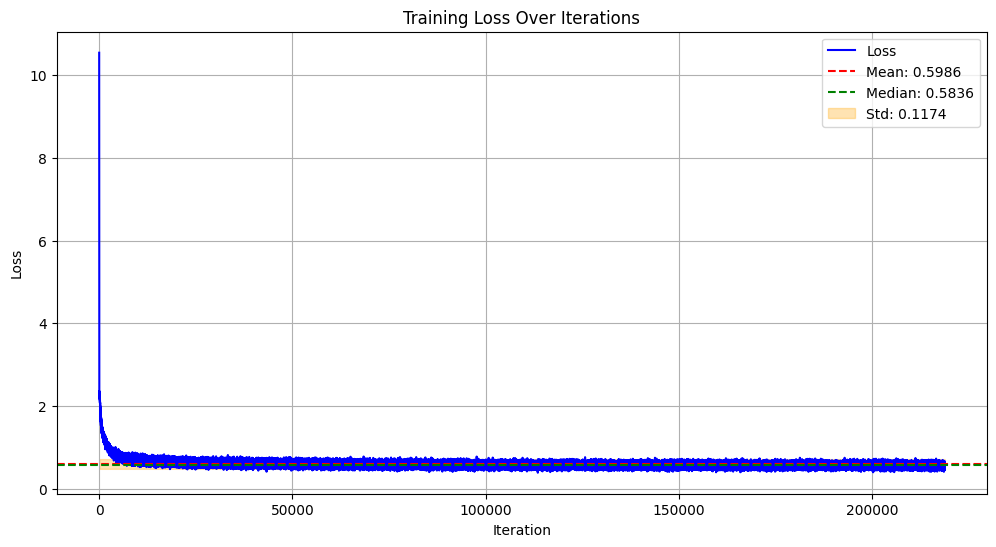

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm 
import matplotlib.pyplot as plt

# get the cuda for faster calculation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the generate dataset from the disk (unfortunately i cannot add this set to github)
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")
#For now the sudoku set comes with numbers 0 - 9 and 0 denotes unknowns , i might change it later to one - hot encoding whitch i guess might be better for CNN 

#Get the batches in order, the set has milion sudokus so the learning might be long 
dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True, num_workers=4)

#CNN Model 
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1 channel (from0 to 9 , 0 denotes unkown), Output: 32 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by a factor of 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input: 32 channels, Output: 64 channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Input: 64 channels, Output: 128  channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by a factor of 2
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 2 * 2, 256),  # Adjust this according to the output size after conv layers
            nn.ReLU(),
            nn.Linear(256, 81)  # Output: 81 values for Sudoku
        )

    def forward(self, x):
        x = x.view(-1, 1, 9, 9)  # Reshape input to (batch_size, channels, height, width)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc_layers(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
losses = []
accuracies = []

# Training the model
num_epochs = 14
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)
        true_classes = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted_classes == true_classes).sum().item()
        total_predictions += true_classes.size(0)

        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_predictions) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate statistics after all epochs
loss_tensor = torch.tensor(losses, dtype=torch.float32)
mean_loss = torch.mean(loss_tensor).item()
std_loss = torch.std(loss_tensor).item()
median_loss = torch.median(loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(losses) + 1), losses, color='b', label='Loss')
ax.axhline(mean_loss, color='r', linestyle='--', label=f'Mean: {mean_loss:.4f}')
ax.axhline(median_loss, color='g', linestyle='--', label=f'Median: {median_loss:.4f}')
ax.fill_between(range(1, len(losses) + 1),
                mean_loss - std_loss,
                mean_loss + std_loss,
                color='orange', alpha=0.3, label=f'Std: {std_loss:.4f}')

ax.set_title('Training Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Epoch 1/2: 100%|██████████| 15625/15625 [01:34<00:00, 165.24it/s, Loss=0.757]


Epoch 1/2, Average Loss: 0.8953, Accuracy: 31.13%


Epoch 2/2: 100%|██████████| 15625/15625 [01:33<00:00, 166.24it/s, Loss=0.597]


Epoch 2/2, Average Loss: 0.6758, Accuracy: 32.04%


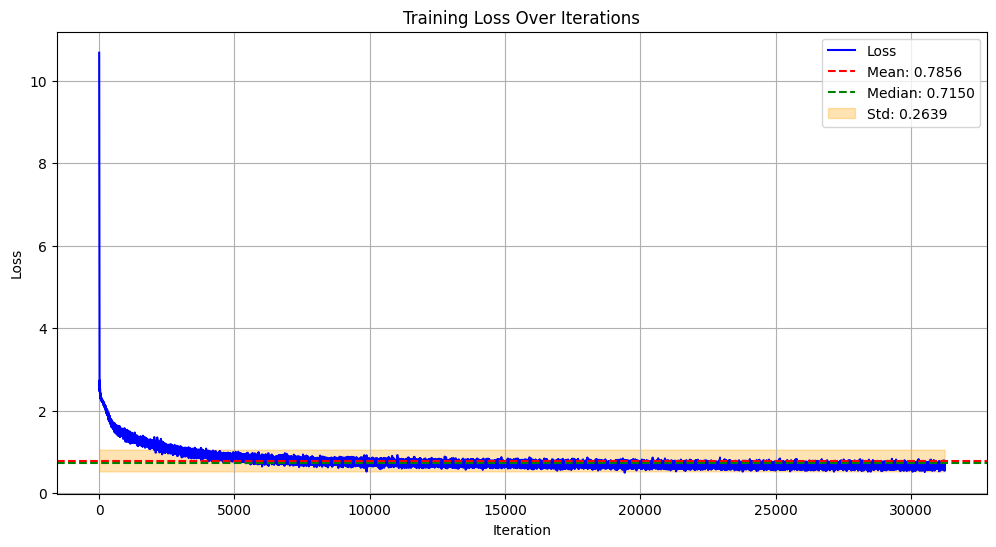

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Create a DataLoader for batch processing
dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define the CNN model
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: 1 channel (grayscale), Output: 32 channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32 channels, Output: 64 channels
        
        # After two pooling operations on 9x9 input:
        # 9 -> 4 after first pooling
        # 4 -> 2 after second pooling
        self.fc1 = nn.Linear(64 * 2 * 2, 128)  # Adjust for 64 channels, 2x2 size after pooling
        self.fc2 = nn.Linear(128, 81)  # Output size remains 81 for the Sudoku grid

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (1 for grayscale)
        x = self.pool(F.relu(self.conv1(x)))  # After conv1 and pool: (32, 9, 9) -> (32, 4, 4)
        x = self.pool(F.relu(self.conv2(x)))  # After conv2 and pool: (64, 4, 4) -> (64, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
losses = []
accuracies = []

# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)
        true_classes = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted_classes == true_classes).sum().item()
        total_predictions += true_classes.size(0)

        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_predictions) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate statistics after all epochs
loss_tensor = torch.tensor(losses, dtype=torch.float32)
mean_loss = torch.mean(loss_tensor).item()
std_loss = torch.std(loss_tensor).item()
median_loss = torch.median(loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(losses) + 1), losses, color='b', label='Loss')
ax.axhline(mean_loss, color='r', linestyle='--', label=f'Mean: {mean_loss:.4f}')
ax.axhline(median_loss, color='g', linestyle='--', label=f'Median: {median_loss:.4f}')
ax.fill_between(range(1, len(losses) + 1),
                mean_loss - std_loss,
                mean_loss + std_loss,
                color='orange', alpha=0.3, label=f'Std: {std_loss:.4f}')

ax.set_title('Training Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Create a DataLoader for batch processing
dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define the neural network model
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the size after convolution and pooling
        self.fc1 = nn.Linear(64 * 2 * 2, 128)  # Update based on your input size
        self.fc2 = nn.Linear(128, 81)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store loss values
losses = []

# Training the model
num_epochs = 5  # Increase as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Print average loss per epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Calculate statistics after all epochs
loss_tensor = torch.tensor(losses, dtype=torch.float32)
mean_loss = torch.mean(loss_tensor).item()
std_loss = torch.std(loss_tensor).item()
median_loss = torch.median(loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(losses) + 1), losses, color='b', label='Loss')
ax.axhline(mean_loss, color='r', linestyle='--', label=f'Mean: {mean_loss:.4f}')
ax.axhline(median_loss, color='g', linestyle='--', label=f'Median: {median_loss:.4f}')
ax.fill_between(range(1, len(losses) + 1),
                mean_loss - std_loss,
                mean_loss + std_loss,
                color='orange', alpha=0.3, label=f'Std: {std_loss:.4f}')

ax.set_title('Training Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Epoch 1/5:   0%|          | 0/15625 [00:04<?, ?it/s]


NameError: name 'F' is not defined

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from datasets import load_from_disk
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Split the dataset into training, validation, and test sets
train_size = int(0.5 * len(loaded_dataset))
val_size = int(0.25 * len(loaded_dataset))
test_size = len(loaded_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(loaded_dataset, [train_size, val_size, test_size])

# Create DataLoaders for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the neural network model
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(128 * 2 * 2, 128)  # Update based on your input size
        self.fc2 = nn.Linear(128, 81)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(nn.ReLU(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLu(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLu(self.bn2(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(nn.ReLu(self.fc1(x)))
        return self.fc2(x)

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 2  # Increase as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_losses.append(loss.item())
        
        progress_bar.set_postfix({'Loss': loss.item()})
    
    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation
        for val_batch in val_dataloader:
            val_inputs = val_batch['input'].float().to(device)
            val_outputs = val_batch['output'].view(-1, 81).float().to(device)

            val_predictions = model(val_inputs)
            val_loss = criterion(val_predictions, val_outputs)
            running_val_loss += val_loss.item()
            val_losses.append(val_loss.item())
    
    avg_val_loss = running_val_loss / len(val_dataloader)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

# Calculate statistics after all epochs
train_loss_tensor = torch.tensor(train_losses, dtype=torch.float32)
val_loss_tensor = torch.tensor(val_losses, dtype=torch.float32)
mean_train_loss = torch.mean(train_loss_tensor).item()
mean_val_loss = torch.mean(val_loss_tensor).item()

# Create a final plot after all epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(train_losses) + 1), train_losses, color='b', label='Training Loss')
ax.plot(range(1, len(val_losses) + 1), val_losses, color='orange', label='Validation Loss')
ax.axhline(mean_train_loss, color='r', linestyle='--', label=f'Mean Train Loss: {mean_train_loss:.4f}')
ax.axhline(mean_val_loss, color='g', linestyle='--', label=f'Mean Val Loss: {mean_val_loss:.4f}')

ax.set_title('Training and Validation Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Training Epoch 1/2:   0%|          | 0/7813 [00:13<?, ?it/s]


TypeError: max_pool2d(): argument 'input' (position 1) must be Tensor, not ReLU

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from datasets import load_from_disk
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Define the transform: normalization by dividing each number by 9
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.float().view(1, 9, 9) / 9.0),  # Reshape and normalize to [0, 1] range
    transforms.Normalize(mean=[0.5], std=[0.3])  # Adjust mean and std based on your normalized data
])

# Define a custom dataset class with transforms
class SudokuDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        input_grid = sample['input']
        output_grid = sample['output']

        if self.transform:
            input_grid = self.transform(input_grid)
            output_grid = self.transform(output_grid)

        return {'input': input_grid, 'output': output_grid}

# Split into training and validation sets
train_size = int(0.67 * len(loaded_dataset))
val_size = len(loaded_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(loaded_dataset, [train_size, val_size])

# Create the DataLoader with the transform
train_dataloader = DataLoader(SudokuDataset(train_dataset, transform=transform), batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(SudokuDataset(val_dataset, transform=transform), batch_size=64, shuffle=False, num_workers=4)

# Define the CNN model
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 9, 256),  # Adjusting the size according to the input image size
            nn.ReLU(),
            nn.Linear(256, 81)  # Output is flattened 9x9 Sudoku grid
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values for training and validation
train_losses = []
val_losses = []

# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    
    # Training phase
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch in progress_bar:
        inputs = batch['input'].to(device)
        outputs = batch['output'].view(-1, 81).to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_losses.append(loss.item())
        
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = batch['input'].to(device)
            outputs = batch['output'].view(-1, 81).to(device)

            predictions = model(inputs)
            val_loss = criterion(predictions, outputs)
            
            val_running_loss += val_loss.item()
            val_losses.append(val_loss.item())

    # Calculate and print average losses
    avg_train_loss = running_loss / len(train_dataloader)
    avg_val_loss = val_running_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Create a plot for the training and validation loss
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_losses, color='b', label='Training Loss')
ax.plot(val_losses, color='orange', label='Validation Loss')
ax.set_title('Training and Validation Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()


Using device: cuda


Epoch 1/2 - Training:   0%|          | 0/10469 [00:00<?, ?it/s]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from datasets import load_from_disk
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset from disk and set format to 'torch' for PyTorch compatibility
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Define transform for normalization using torchvision.transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 9)  # Normalize by dividing by 9
])

# Create training and validation datasets (50% each)
train_size = int(0.5 * len(loaded_dataset))
val_size = len(loaded_dataset) - train_size
train_dataset, val_dataset = random_split(loaded_dataset, [train_size, val_size])

# Custom Dataset class to apply transformation
class SudokuDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        input_data = sample['input']
        output_data = sample['output']

        if self.transform:
            input_data = self.transform(input_data)
            output_data = self.transform(output_data)

        return {'input': input_data, 'output': output_data}

# Create DataLoader for training and validation sets
train_dataloader = DataLoader(SudokuDataset(train_dataset, transform=transform), batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(SudokuDataset(val_dataset, transform=transform), batch_size=32, shuffle=False, num_workers=4)

# Define a CNN model for Sudoku
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel, 32 output channels, 3x3 kernel
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 output channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128 output channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Reduce dimension by pooling
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # Flattening dimension
            nn.ReLU(),
            nn.Linear(512, 81)  # Output 81 numbers
        )

    def forward(self, x):
        x = x.view(-1, 1, 9, 9)  # Reshape to (batch_size, channels, height, width)
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SudokuCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 5  # Number of epochs to train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Training phase
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for batch in progress_bar:
        inputs = batch['input'].float().to(device)
        outputs = batch['output'].view(-1, 81).float().to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_losses.append(loss.item())
        progress_bar.set_postfix({'Training Loss': loss.item()})

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        for batch in progress_bar:
            inputs = batch['input'].float().to(device)
            outputs = batch['output'].view(-1, 81).float().to(device)

            predictions = model(inputs)
            loss = criterion(predictions, outputs)
            val_running_loss += loss.item()
            val_losses.append(loss.item())
            progress_bar.set_postfix({'Validation Loss': loss.item()})

    # Print average loss per epoch
    avg_train_loss = running_loss / len(train_dataloader)
    avg_val_loss = val_running_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}")

# Plot training and validation losses
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(train_losses) + 1), train_losses, color='b', label='Training Loss')
ax.plot(range(1, len(val_losses) + 1), val_losses, color='r', label='Validation Loss')
ax.set_title('Training and Validation Loss Over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()  # Display the final plot


Using device: cuda


Epoch 1/5 [Training]:   0%|          | 0/15625 [00:00<?, ?it/s]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 7, 6, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 9, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 8, 0, 5, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 4, 0, 0],
        [0, 0, 0, 0, 0, 0, 6, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[2, 9, 5, 0, 0, 0, 0, 0, 0],
        [1, 3, 8, 0, 0, 0, 0, 0, 0],
        [4, 7, 6, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 7, 2, 9, 0, 0, 0],
        [0, 0, 0, 4, 1, 6, 0, 0, 0],
        [0, 0, 0, 8, 3, 5, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 4, 2, 8],
        [0, 0, 0, 0, 0, 0, 6, 5, 3],
        [0, 0, 0, 0, 0, 0, 9, 7, 1]])


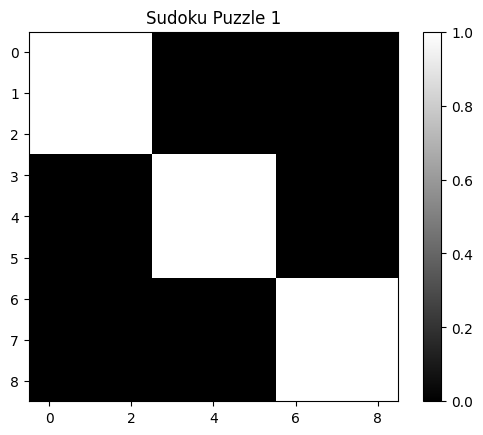

tensor([[6, 4, 0, 0, 0, 0, 0, 0, 0],
        [8, 2, 0, 0, 0, 0, 0, 0, 0],
        [7, 5, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 9, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 4, 2, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 6, 3, 8],
        [0, 0, 0, 0, 0, 0, 0, 9, 0],
        [0, 0, 0, 0, 0, 0, 4, 7, 5]])
tensor([[6, 4, 9, 0, 0, 0, 0, 0, 0],
        [8, 2, 1, 0, 0, 0, 0, 0, 0],
        [7, 5, 3, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 9, 7, 8, 0, 0, 0],
        [0, 0, 0, 1, 4, 2, 0, 0, 0],
        [0, 0, 0, 5, 3, 6, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 6, 3, 8],
        [0, 0, 0, 0, 0, 0, 2, 9, 1],
        [0, 0, 0, 0, 0, 0, 4, 7, 5]])


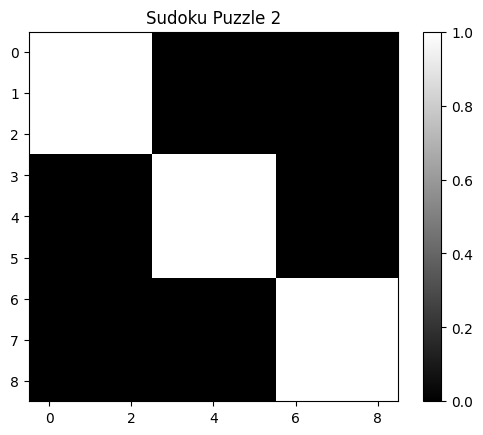

tensor([[5, 0, 6, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0],
        [7, 4, 8, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 9, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 6, 7, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 4, 0],
        [0, 0, 0, 0, 0, 0, 8, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[5, 1, 6, 0, 0, 0, 0, 0, 0],
        [9, 3, 2, 0, 0, 0, 0, 0, 0],
        [7, 4, 8, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 4, 2, 9, 0, 0, 0],
        [0, 0, 0, 8, 5, 3, 0, 0, 0],
        [0, 0, 0, 6, 7, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 4, 2],
        [0, 0, 0, 0, 0, 0, 8, 1, 5],
        [0, 0, 0, 0, 0, 0, 6, 7, 9]])


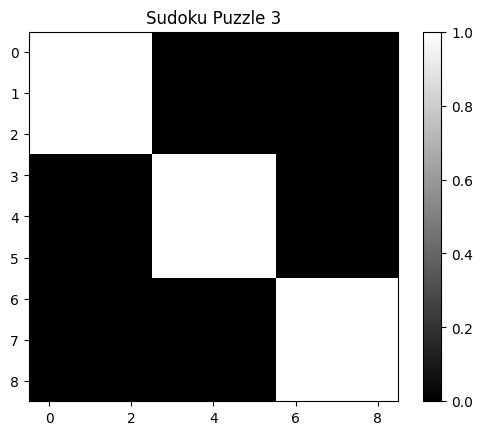

tensor([[3, 0, 8, 0, 0, 0, 0, 0, 0],
        [5, 6, 7, 0, 0, 0, 0, 0, 0],
        [0, 4, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 6, 2, 0, 0, 0],
        [0, 0, 0, 8, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 9, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 6, 7, 1]])
tensor([[3, 2, 8, 0, 0, 0, 0, 0, 0],
        [5, 6, 7, 0, 0, 0, 0, 0, 0],
        [9, 4, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 5, 9, 0, 0, 0],
        [0, 0, 0, 7, 6, 2, 0, 0, 0],
        [0, 0, 0, 8, 4, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 9, 2],
        [0, 0, 0, 0, 0, 0, 8, 4, 5],
        [0, 0, 0, 0, 0, 0, 6, 7, 1]])


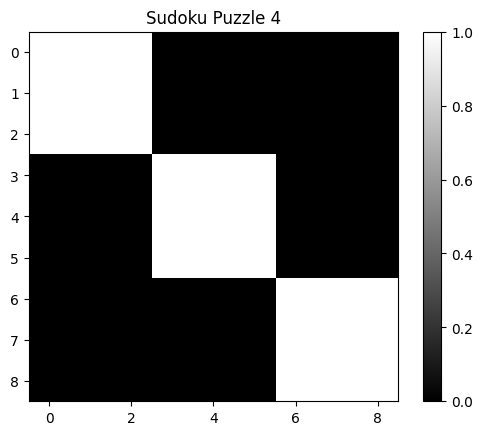

tensor([[6, 1, 5, 0, 0, 0, 0, 0, 0],
        [9, 4, 8, 0, 0, 0, 0, 0, 0],
        [3, 0, 7, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 9, 1, 7, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 6, 0, 5, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 4, 6]])
tensor([[6, 1, 5, 0, 0, 0, 0, 0, 0],
        [9, 4, 8, 0, 0, 0, 0, 0, 0],
        [3, 2, 7, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 9, 1, 7, 0, 0, 0],
        [0, 0, 0, 2, 4, 8, 0, 0, 0],
        [0, 0, 0, 6, 3, 5, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 8, 1, 5],
        [0, 0, 0, 0, 0, 0, 3, 7, 9],
        [0, 0, 0, 0, 0, 0, 2, 4, 6]])


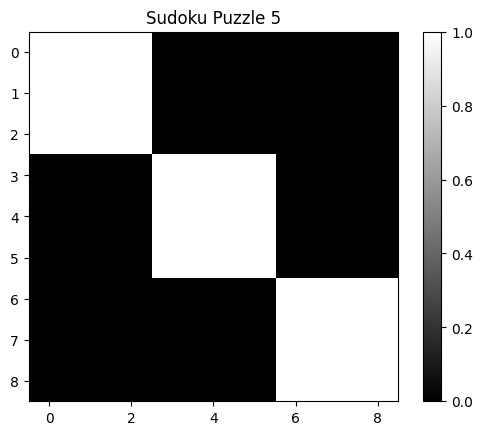

In [9]:
import matplotlib.pyplot as plt
from datasets import load_from_disk

# Load the dataset from disk and set the format to 'torch'
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Function to display a single Sudoku puzzle
def show_sudoku(data, title="Sudoku Puzzle"):
    # Reshape the data to a 9x9 grid (since it's normalized)
    puzzle = data.view(9, 9)
    
    plt.imshow(puzzle, cmap='gray', vmin=0, vmax=1)  # Display the puzzle
    plt.colorbar()  # Optional: display a color bar
    plt.title(title)
    plt.show()

# Display a few examples from the dataset
num_examples = 5  # Number of examples to show
for i in range(num_examples):
    # Extract puzzle and solution
    puzzle = loaded_dataset[i]['input']  # Assuming 'input_ids' holds the puzzle data
    solution = loaded_dataset[i]['output']    # Assuming 'label' holds the solution
    print(puzzle)
    print(solution)
    
    # Display the Sudoku puzzle
    show_sudoku(solution, title=f"Sudoku Puzzle {i+1}")
